<a href="https://colab.research.google.com/github/Akanksha-neural-networks/miniproject4/blob/main/Resnet50.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import files
uploaded = files.upload()

Saving PD_Class_yolov8.v2i.clip.zip to PD_Class_yolov8.v2i.clip.zip


In [2]:
import zipfile
import io

zip_file_name = 'PD_Class_yolov8.v2i.clip.zip'

with zipfile.ZipFile(io.BytesIO(uploaded[zip_file_name]), 'r') as zip_ref:
    zip_ref.extractall('/content/')

In [3]:
from keras.layers import Input,Lambda,Dense,Flatten,Dropout, Conv2D, MaxPooling2D, BatchNormalization, GlobalAveragePooling2D, Activation, Concatenate
from keras.models import Model
from keras.applications.resnet50 import ResNet50
from keras.preprocessing import image
from keras.preprocessing.image import ImageDataGenerator
import numpy as np
from glob import glob
import matplotlib.pyplot as plt

In [4]:
train_pd = "/content/PD_Class_yolov8.v2i.clip/train"
test_pd = "/content/PD_Class_yolov8.v2i.clip/test"
valid_df = "/content/PD_Class_yolov8.v2i.clip/valid"

In [5]:
print(train_pd,test_pd,valid_df)

/content/PD_Class_yolov8.v2i.clip/train /content/PD_Class_yolov8.v2i.clip/test /content/PD_Class_yolov8.v2i.clip/valid


In [6]:
import os
import cv2
x_train=[]
for folder in os.listdir(train_pd):
    sub_path=train_pd+"/"+folder
    for img in os.listdir(sub_path):
        image_path=sub_path+"/"+img
        img_arr=cv2.imread(image_path)
        img_arr=cv2.resize(img_arr,(224,224))
        x_train.append(img_arr)

In [7]:
x_test=[]
for folder in os.listdir(test_pd):
    sub_path=test_pd+"/"+folder
    for img in os.listdir(sub_path):
        image_path=sub_path+"/"+img
        img_arr=cv2.imread(image_path)
        img_arr=cv2.resize(img_arr,(224,224))
        x_test.append(img_arr)

In [8]:
x_val=[]
for folder in os.listdir(valid_df):
    sub_path=test_pd+"/"+folder
    for img in os.listdir(sub_path):
        image_path=sub_path+"/"+img
        img_arr=cv2.imread(image_path)
        img_arr=cv2.resize(img_arr,(224,224))
        x_val.append(img_arr)

In [9]:
train_x=np.array(x_train)
test_x=np.array(x_test)
val_x=np.array(x_val)

In [10]:
train_x=train_x/255.0
test_x=test_x/255.0
val_x=val_x/255.0

In [11]:
train_datagen = ImageDataGenerator(rescale = 1./255,
                                   rotation_range=20,
                                   width_shift_range=0.4,
                                   height_shift_range=0.4,
                                   shear_range=0.2,
                                   zoom_range=0.2,
                                   horizontal_flip=True,
                                   fill_mode='nearest')
test_datagen = ImageDataGenerator(rescale = 1./255,
                                  rotation_range=20,
                                   width_shift_range=0.4,
                                   height_shift_range=0.4,
                                   shear_range=0.2,
                                   zoom_range=0.2,
                                   horizontal_flip=True,
                                   fill_mode='nearest')
val_datagen = ImageDataGenerator(rescale = 1./255,
                                 rotation_range=20,
                                   width_shift_range=0.4,
                                   height_shift_range=0.4,
                                   shear_range=0.2,
                                   zoom_range=0.2,
                                   horizontal_flip=True,
                                   fill_mode='nearest')

In [12]:
training_set = train_datagen.flow_from_directory(train_pd,
                                                 target_size = (224, 224),
                                                 batch_size = 32,
                                                 class_mode = 'sparse')
test_set = test_datagen.flow_from_directory(test_pd,
                                            target_size = (224, 224),
                                            batch_size = 32,
                                            class_mode = 'sparse')
val_set = val_datagen.flow_from_directory(valid_df,
                                            target_size = (224, 224),
                                            batch_size = 32,
                                            class_mode = 'sparse')

Found 1120 images belonging to 2 classes.
Found 320 images belonging to 2 classes.
Found 160 images belonging to 2 classes.


In [13]:
train_y=training_set.classes
test_y=test_set.classes
val_y=val_set.classes

In [14]:
training_set.class_indices
train_y.shape,test_y.shape,val_y.shape

((1120,), (320,), (160,))

In [15]:
def show_img(image_generator, num_images=10):
    images, labels = image_generator.next()
    fig, axes = plt.subplots(1, num_images, figsize=(15,3))
    for i in range(num_images):
        axes[i].imshow(images[i])
        axes[i].axis('off')
    plt.show()

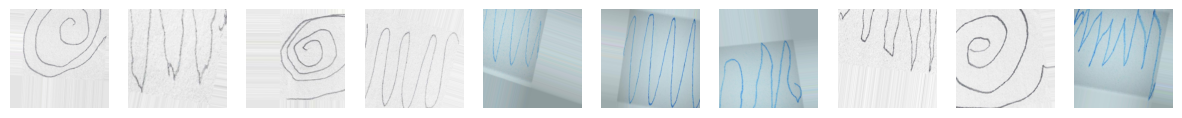

In [16]:
show_img(training_set)

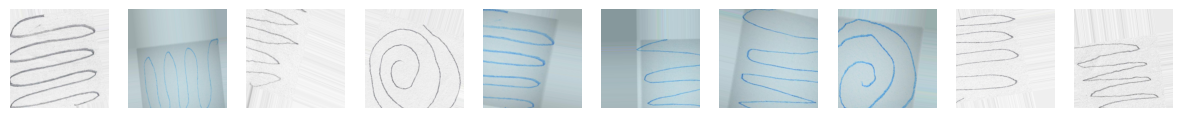

In [17]:
show_img(test_set)

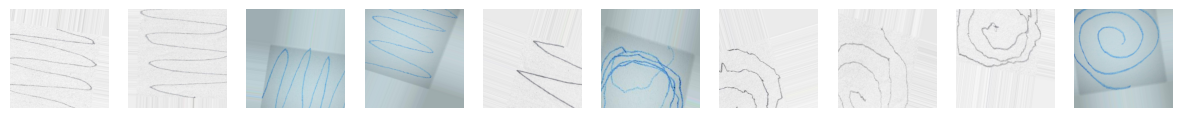

In [18]:
show_img(val_set)

In [19]:
#adding the pre processing layer infront of resnet
resnet=ResNet50(input_shape=(224,224,3),weights='imagenet',include_top=False)

94765736/94765736 [==============================] - 1s 0us/step


In [20]:
#this is for not training the existing weights
for layer in resnet.layers:
  layer.trainable=False

In [21]:
#our layers
x=Flatten()(resnet.output)
x = Dense(512, activation='relu')(x)
x = Dropout(0.5)(x)

In [22]:
x=Dense(256,activation='relu')(x)
pred=Dense(1,activation='sigmoid')(x)

In [23]:
#creating the model object
model=Model(inputs=resnet.input,outputs=pred)

In [24]:
#to view the structure of our model
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 224, 224, 3)]        0         []                            
                                                                                                  
 conv1_pad (ZeroPadding2D)   (None, 230, 230, 3)          0         ['input_1[0][0]']             
                                                                                                  
 conv1_conv (Conv2D)         (None, 112, 112, 64)         9472      ['conv1_pad[0][0]']           
                                                                                                  
 conv1_bn (BatchNormalizati  (None, 112, 112, 64)         256       ['conv1_conv[0][0]']          
 on)                                                                                          

In [26]:
from tensorflow.keras.optimizers import Adam
optimizer = Adam(learning_rate=0.0001)
model.compile(optimizer=optimizer, loss='binary_crossentropy', metrics=['accuracy'])

In [27]:
#fit the model
r=model.fit(training_set,validation_data=test_set,epochs=100)

Epoch 1/100
35/35 [==============================] - 32s 661ms/step - loss: 0.8973 - accuracy: 0.5009 - val_loss: 0.7624 - val_accuracy: 0.5000
Epoch 2/100
35/35 [==============================] - 21s 590ms/step - loss: 0.8160 - accuracy: 0.5000 - val_loss: 0.7336 - val_accuracy: 0.5000
Epoch 3/100
35/35 [==============================] - 21s 608ms/step - loss: 0.7551 - accuracy: 0.4982 - val_loss: 0.6930 - val_accuracy: 0.5125
Epoch 4/100
35/35 [==============================] - 21s 610ms/step - loss: 0.7341 - accuracy: 0.5080 - val_loss: 0.6980 - val_accuracy: 0.4906
Epoch 5/100
35/35 [==============================] - 21s 615ms/step - loss: 0.7103 - accuracy: 0.4768 - val_loss: 0.6948 - val_accuracy: 0.5000
Epoch 6/100
35/35 [==============================] - 20s 586ms/step - loss: 0.6924 - accuracy: 0.5295 - val_loss: 0.7051 - val_accuracy: 0.5000
Epoch 7/100
35/35 [==============================] - 21s 610ms/step - loss: 0.7036 - accuracy: 0.4875 - val_loss: 0.6947 - val_accuracy:

In [28]:
test_eval = model.evaluate(test_set)

10/10 [==============================] - 5s 521ms/step - loss: 0.6931 - accuracy: 0.5000


In [29]:
training_accuracy = r.history['accuracy'][-1]
print(f"Final Training Accuracy: {training_accuracy * 100:.2f}%")
print(f"Test Loss: {test_eval[0]:.4f}")
print(f"Test Accuracy: {test_eval[1] * 100:.2f}%")

Final Training Accuracy: 48.04%
Test Loss: 0.6931
Test Accuracy: 50.00%


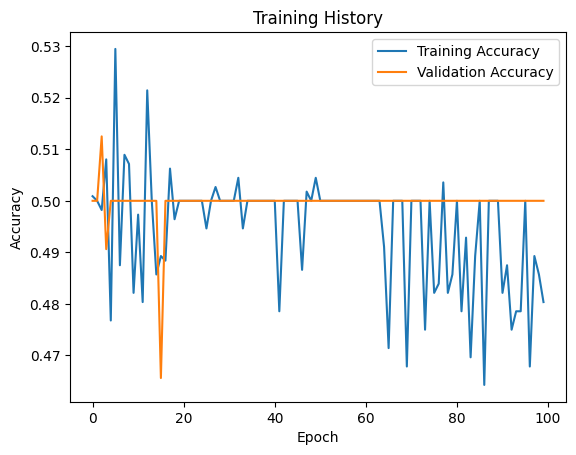

In [30]:
plt.plot(r.history['accuracy'], label='Training Accuracy')
plt.plot(r.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Training History')
plt.legend()
plt.show()

In [31]:
predictions = model.predict(test_set)
y_pred = (predictions > 0.5).astype(int).flatten()

10/10 [==============================] - 5s 420ms/step


In [32]:
y_true = test_set.classes

In [33]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

In [34]:
accuracy = accuracy_score(y_true, y_pred)
precision = precision_score(y_true, y_pred)
recall = recall_score(y_true, y_pred)
f1 = f1_score(y_true, y_pred)

In [35]:
print("Accuracy:",accuracy)
print("Precision:",precision)
print("Recall:",recall)
print("F1 Score:",f1)

Accuracy: 0.5
Precision: 0.5
Recall: 1.0
F1 Score: 0.6666666666666666


In [36]:
from sklearn.metrics import confusion_matrix, classification_report
cm = confusion_matrix(y_true, y_pred)
print("Confusion Matrix:")
print(cm)

Confusion Matrix:
[[  0 160]
 [  0 160]]


In [37]:
print("Classification Report:")
print(classification_report(y_true, y_pred))

Classification Report:
              precision    recall  f1-score   support

           0       0.00      0.00      0.00       160
           1       0.50      1.00      0.67       160

    accuracy                           0.50       320
   macro avg       0.25      0.50      0.33       320
weighted avg       0.25      0.50      0.33       320



/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


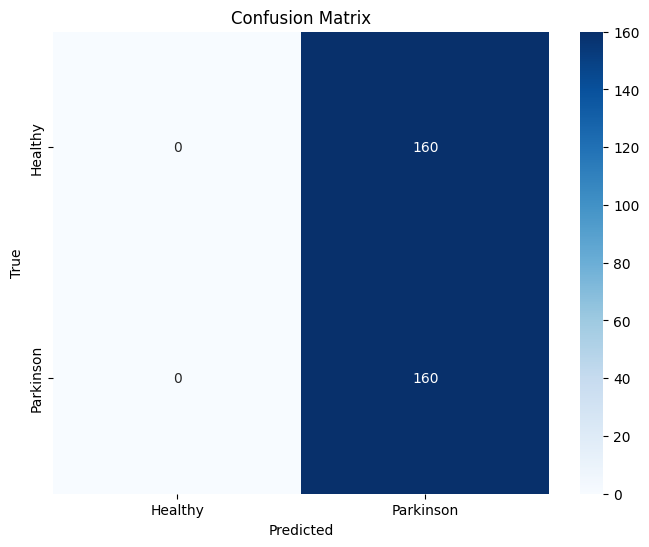

In [38]:
import seaborn as sns
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Healthy', 'Parkinson'], yticklabels=['Healthy', 'Parkinson'])
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()